# <b>-- Telecom. Company Customer Churn --</b>
#### Author : <i>Fábio Marane</i>

---
This project uses <b>Supervised Machine Learning</b> algorithms to <b>predict customer churn</b> for a hypothetical telecommunications company.
 Foremost, the data is retrieved from a CSV file available in <i>Kaggle</i>. Then, the data is <b>balanced, labeled, separated and applied into 9 different algorithms</b> - one of them used as a baseline. Then, the results are gathered and for further comparison. The algorithms used belongs to the modules <i>Scikit-Learn and XGBoost</i>:
- Logistic Regression (baseline);
- Support Vector Classifier;
- K-Nearest Neighbors (Both Euclidean and Chebyshev metrics);
- Gaussian and Bernoulli Naïve-Bayes Classifier;
- Decision Tree Classifier;
- Random Forest Classifier;
- XGBoost Classifier.


Source: https://www.kaggle.com/datasets/mnassrib/telecom-churn-datasets?select=churn-bigml-20.csv

### 1. Data Manipulation and Analysis
#### 1.1 Importing modules

In [91]:
import pandas as pd                 #Data manipulation
import numpy as np                  #Data manipulation
import plotly.graph_objs as go      #Data visualization
import plotly.offline as py
from plotly.subplots import make_subplots

#### 1.2 Collecting data


In [92]:
data = pd.read_csv('churn_dataset.csv')

print(data.shape)   #Obtaining table dimensions
data    #First contact with the data

(2666, 20)


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,SC,79,415,No,No,0,134.7,98,22.90,189.7,68,16.12,221.4,128,9.96,11.8,5,3.19,2,False
2662,AZ,192,415,No,Yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
2663,WV,68,415,No,No,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
2664,RI,28,510,No,No,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False


#### 1.3 Obtaining statistical metrics of the raw data

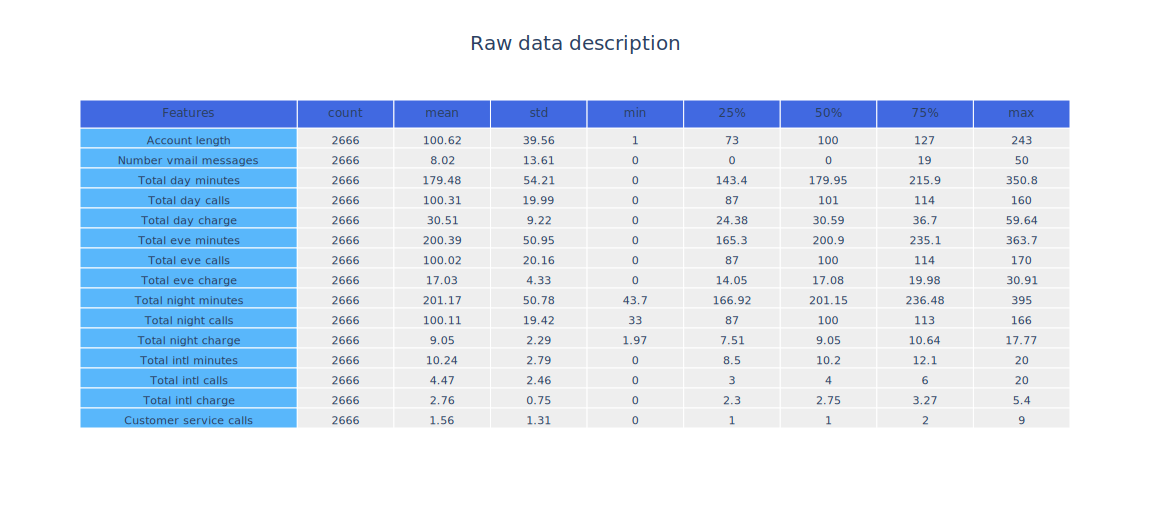

In [93]:
description = data.drop(['State', 'Area code'], axis = 1).describe().round(2).transpose().reset_index()     #Temporary removal of the categorical columns
description.rename(columns = {'index' : 'Features'}, inplace = True)    #Renaming index properly


#Plotting a table containing statistical metrics of all numerical columns
fig = go.Figure()

fig.add_trace(go.Table(header = dict(values = description.columns.tolist(),
                                     fill = dict(color = ['RoyalBlue'])),
                       cells = dict(values = description.transpose().values.tolist(),
                                    fill = dict(color = ['#59b7fb', '#eeeeee']),
                                    font = dict(size = 11)),
                       columnwidth = [180, 80, 80, 80, 80, 80, 80, 80, 80],
                       )
              )

fig.update_layout(width = 1150,
                  height = 520,
                  title = dict(text = 'Raw data description',
                               x = 0.5,
                               font = dict(size = 20)
                               )
                  )
fig.show('svg')

#### 1.4 Obtaining the proportion of the class vector

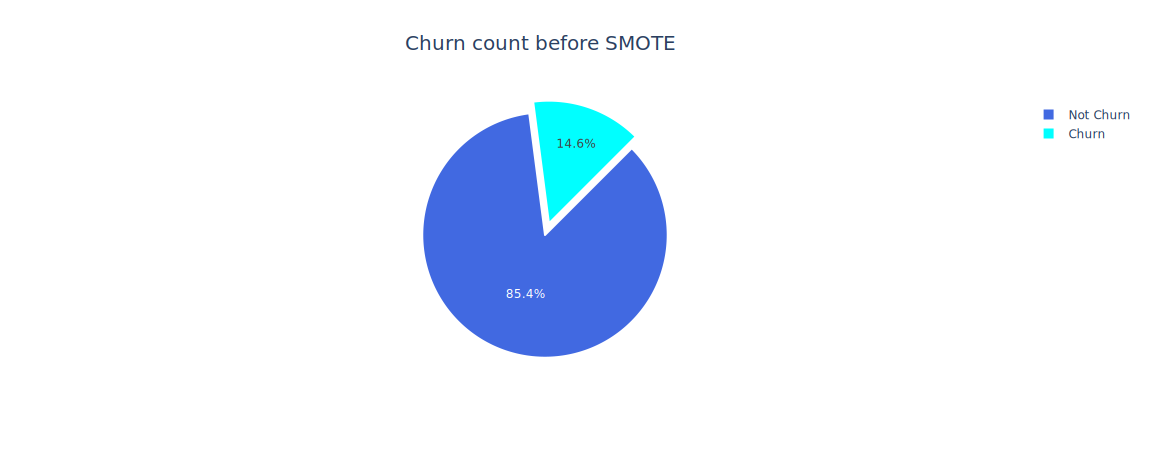

In [94]:
#Mapping the output vector properly, and plotting the count before balancing
fig = go.Figure()

map = {True : 'Churn',
       False : 'Not Churn'}

label = data['Churn'].map(map).value_counts().keys().tolist()

fig.add_trace(go.Pie(labels = label,
                     values = data['Churn'].value_counts().tolist(),
                     marker = dict(colors = ['RoyalBLue', 'Aqua'],
                                   line = dict(color = 'white', width = 2.0)),
                     rotation = 45,
                     hoverinfo = 'label+value+text',
                     pull = [0, 0.1]
                     )
              )
fig.update_layout(title = dict(text = 'Churn count before SMOTE',
                               x = 0.47,
                               font = dict(size = 20)
                               ),
                  width = 1150,
                  height = 450
                  )
fig.show('svg')

In [95]:
T = data[data['Churn'] == True]['Churn'].count()
F = data[data['Churn'] == False]['Churn'].count()
proportion = F/T

print(f"There are {proportion} 'Not Churn' to each 'Churn'")

There are 5.871134020618556 'Not Churn' to each 'Churn'


#### 1.5 Labeling categorical columns

In [96]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
d_copy = data.copy()
str_columns = data.select_dtypes(include = object).columns
for i in str_columns:
    data[i] = LE.fit_transform(data[i].astype(str))

In [97]:
#Creating a relation dataframe for the labeled data
state_dict = {
    'state': d_copy['State'].drop_duplicates(),
    'state_num': data['State'].drop_duplicates()
}
state_df = pd.DataFrame(state_dict)

state_df = state_df.sort_values('state')

state_df.head(5)

,state,state_num
32,AK,0
5,AL,1
36,AR,2
19,AZ,3
51,CA,4


#### 1.6 Balancing data via Synthetic Minority Oversampling Technique (SMOTE)

In [98]:
from imblearn.over_sampling import SMOTE

np.random.seed(7)

raw_X = data.drop('Churn', axis = 1)
raw_y = data['Churn']

sm = SMOTE()
raw_X, raw_y = sm.fit_resample(raw_X, raw_y)
data = pd.concat([raw_X, raw_y], axis = 1)

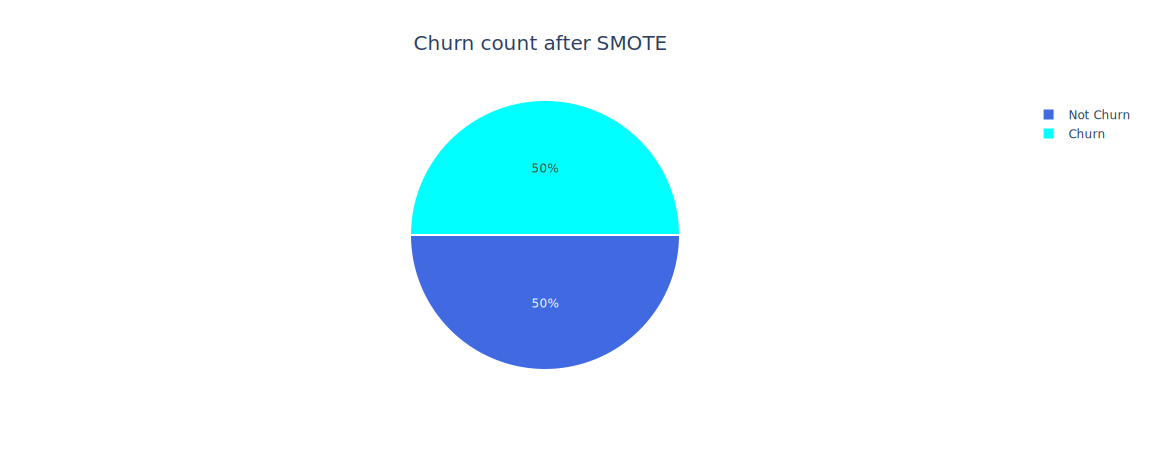

In [99]:
#Plotting the balanced data

fig = go.Figure()

label = data['Churn'].map(map).value_counts().keys().tolist()

fig.add_trace(go.Pie(labels = label,
                     values = data['Churn'].value_counts().tolist(),
                     marker = dict(colors = ['RoyalBLue', 'Aqua'],
                                   line = dict(color = 'white', width = 2.0)),
                     rotation = 90,
                     hoverinfo = 'label+value+text'
                     )
              )
fig.update_layout(title = dict(text = 'Churn count after SMOTE',
                               x = 0.47,
                               font = dict(size = 20)
                               ),
                  width = 1150,
                  height = 450,
                  )
fig.show('svg')

#### 1.7 Correlation Matrix


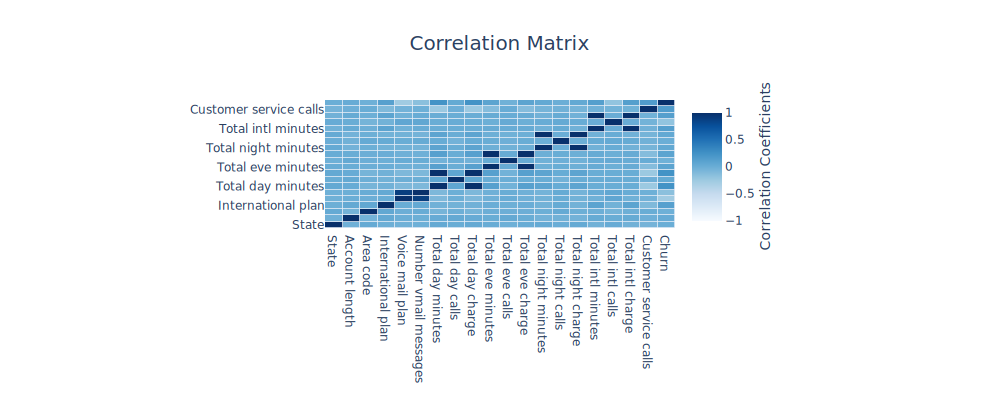

In [117]:
correlation = data.corr()
mask = np.tril(np.ones_like(correlation, dtype = bool))     #Creating a mask for making the matrix triangular
corr_cols = data.corr().keys().tolist()

fig = go.Figure()

fig.add_trace(go.Heatmap(z = correlation, x = corr_cols, y = corr_cols,
                         xgap = 0.8, ygap = 0.8,
                         zmin = -1, zmax = 1,
                         hoverinfo = None,
                         colorscale = 'Blues',
                         colorbar = dict(title = 'Correlation Coefficients',
                                         titleside = 'right',
                                         y = 0.48),
                         )
              )

fig.update_layout(title = dict(text = 'Correlation Matrix',
                               x = 0.5,
                               font = dict(size = 20)
                               ),
                  height = 400,
                  width = 1000,
                  margin = dict(l = 325, r = 325),
                  xaxis_showgrid = False,
                  yaxis_showgrid = False
                  )
fig.show('svg')

#### 1.8 Scaling and separating the train/test data

In [101]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

raw_X = data.drop('Churn', axis = 1)
y = data['Churn']

scaler = StandardScaler()
X = scaler.fit_transform(raw_X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## 2. Construction of the models and reports
#### 2.1 Models construction

In [102]:
#Importing models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#Class containing all models and parameters
class Models:

    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

#Logistic Regression
    def lr(self):
        lr = LogisticRegression(multi_class = 'ovr', n_jobs = 1, solver = 'liblinear')
        results = self.results(lr, 'Logistic Regression - baseline model')
        return results

#Support Vector Machine
    def svc(self):
        svc = SVC(kernel = 'linear', gamma = 'auto', probability = True)
        results = self.results(svc, 'Support Vector Classifier')
        return results

#K-Nearest Neighbors, Euclidean Metric
    def knn_euclidean(self):
        knn_euclidean = KNeighborsClassifier(leaf_size=30, metric='euclidean', n_neighbors = 5)
        results = self.results(knn_euclidean, 'K-Nearest Neighbors/Euclidean Metric')
        return results

#K-Nearest Neighbors, Chebyshev Metric
    def knn_chebyshev(self):
        knn_chebyshev = KNeighborsClassifier(metric = 'chebyshev')
        results = self.results(knn_chebyshev, 'K-Nearest Neighbors/Chebyshev Metric')
        return results

#Gaussian Naïve-Bayes
    def gnb(self):
        gnb = GaussianNB()
        results = self.results(gnb, 'Gaussian Naïve-Bayes')
        return results

#Bernoulli Naïve-Bayes
    def bnb(self):
        bnb = BernoulliNB()
        results = self.results(bnb, 'Bernoulli Naïve-Bayes')
        return results

#Decision Tree Classifier
    def dtc(self):
        dtc = DecisionTreeClassifier(max_depth = 10, criterion = 'entropy')
        results = self.results(dtc, 'Decision Tree Classifier')
        return results

#Random Forest Classifier
    def rfc(self):
        rfc = RandomForestClassifier(max_depth = 10, criterion = 'entropy')
        results = self.results(rfc, 'Random Forest Classifier')
        return results

#XGBoost Classifier
    def xgb(self):
        xgb = XGBClassifier(max_depth = 10)
        results = self.results(xgb, 'XGBoost Classifier')
        return results

#Method for the applying each model
    def results(self, model, model_name):
        model.fit(self.X_train, self.y_train)
        prediction = model.predict(self.X_test)
        probabilities = model.predict_proba(self.X_test)
        report = Report(prediction, probabilities, model_name, self.y_test)
        return report.metrics()     #Printing a table containing the model metrics


#### 2.2 Partial report construction

In [103]:
#List for storing the partial report of each model
metrics_list = []

#Class for partial and final report
class Report:

    def __init__(self, prediction, probabilities, model_name, y_test):
        self.prediction = prediction
        self.probabilities = probabilities
        self.model_name = model_name
        self.y_test = y_test

        self.accuracy = None
        self.precision_score = None
        self.recall_score = None
        self.f1_score = None
        self.roc_auc = None

#Method for obtaining the model metrics
    def metrics(self):
        from sklearn.metrics import (accuracy_score,
                                     confusion_matrix,
                                     precision_score,
                                     recall_score,
                                     roc_auc_score,
                                     roc_curve,
                                     f1_score)

        self.accuracy = accuracy_score(self.y_test, self.prediction)
        self.recall_score = recall_score(self.y_test, self.prediction)
        self.precision_score = precision_score(self.y_test, self.prediction)
        self.f1_score = f1_score(self.y_test, self.prediction)
        self.roc_auc = roc_auc_score(self.y_test, self.prediction)

#Appending the metrics to the previously created list
        metrics_list.append([self.accuracy,
                             self.precision_score,
                             self.recall_score,
                             self.roc_auc,
                             self.f1_score])

        cm = confusion_matrix(self.y_test, self.prediction)

        fpr, tpr, thresholds = roc_curve(self.y_test, self.probabilities[:,1])

#Creating a dataframe for the metrics of each model
        report_table = pd.DataFrame({'Accuracy' : [self.accuracy],
                                     'Precision score' : [self.precision_score],
                                     'Recall score' : [self.recall_score],
                                     'F1 score' : [self.f1_score],
                                     'Area under ROC curve' : [self.roc_auc]
                                     })

#Confusion Matrix plot
        x = ['Not Churn', 'Churn']
        y = ['Not<br>Churn', 'Churn']
        annotations = [['TN', 'FN'],
                       ['FP', 'TP']]

        fig = make_subplots(rows = 2, cols = 2,
                            subplot_titles = ('Confusion Matrix', 'ROC Curve', 'Rates per threshold')
                            )

        fig.add_trace(go.Heatmap(z = cm, x = x, y = y,
                                 xgap = 3, ygap = 3,
                                 colorscale = 'Blues',
                                 text = annotations,
                                 texttemplate = '%{text}',
                                 textfont= {'size':20},
                                 colorbar = dict(len = 0.465,
                                                 orientation = 'h',
                                                 x = 0.223,
                                                 y = 0.48,
                                                 )
                                 ),
                      row = 1, col = 1
                      )
        fig.update_yaxes(title_text = 'Predicted',
                         title_font = dict(size = 16,
                                           color = 'RoyalBlue'),
                         row = 1, col = 1,
                         title_standoff = 0.5
                         )
        fig.update_xaxes(title_text = 'Real value',
                         title_font = dict(size = 16,
                                           color = 'RoyalBlue'),
                         row = 1, col = 1
                         )


        fig.add_trace(go.Scatter(x = fpr,
                                 y = tpr,
                                 line = dict(color = 'RoyalBlue', width = 2),
                                 showlegend = False),
                      row = 1, col = 2)
        fig.update_yaxes(title_text = 'TP Rate',
                         row = 1, col = 2,
                         title_font = dict(size = 16,
                                           color = 'RoyalBlue'),
                         title_standoff = 0.5
                         )
        fig.update_xaxes(title_text = 'FP Rate',
                         title_font = dict(size = 16,
                                           color = 'RoyalBlue'),
                         tickvals = [0.5, 1],
                         row = 1, col = 2
                         )


        fig.add_trace(go.Scatter(x = fpr,
                                 y = thresholds,
                                 name = 'FP rate'),
                      row = 2, col = 1)
        fig.add_trace(go.Scatter(x = tpr,
                                 y = thresholds,
                                 name = 'TP rate'),
                      row = 2, col = 1)
        fig.update_yaxes(title_text = 'Values',
                         title_font = dict(size = 16,
                                           color = 'RoyalBlue'),
                         row = 2, col = 1,
                         title_standoff = 0)
        fig.update_xaxes(title_text = 'Thresholds',
                         title_font = dict(size = 16,
                                           color = 'RoyalBlue'),
                         tickvals = [0.5, 1],
                         row = 2, col = 1,
                         title_standoff = 0)


        fig.update_annotations(font_size = 18)
        fig.update_layout(title = dict(text = self.model_name,
                                       x = 0.5,
                                       font = dict(size = 20)
                                       ),
                          title_font = dict(size = 25,
                                            color = 'RoyalBlue',
                                            family = 'Arial'),
                          width = 1150,
                          height = 900,
                          legend = dict(x = 0.34,
                                        y = 0.32),
                          template = 'plotly_white')

        fig.show('svg')

        return report_table     #Returning a table containing the model metrics

#### 2.3 Final report construction

In [104]:
class FinalReport:

    def __init__(self):

#Creating a dataframe containing the partial reports of all models
        self.report_df = pd.DataFrame(metrics_list, columns = [f'Accuracy',
                                                               f'Precision Score',
                                                               f'Recall Score',
                                                               f'F1 score',
                                                               f'Area under ROC curve']).round(4)

        index = ['Logistic Regression (baseline)',
                 'Support Vector Classifier',
                 'K-Nearest Neighbors/Euclidean',
                 'K-Nearest Neighbors/Chebyshev',
                 'Gaussian Naïve-Bayes',
                 'Bernoulli Naïve-Bayes',
                 'Decision Tree Classifier',
                 'Random Forest Classifier',
                 'XGBoost Classifier']

        self.report_df.insert(0, 'Model', index)
        self.report_df = self.report_df.sort_values('Accuracy')

#Method for table plot construction
    def metrics_table(self):
        fig = go.Figure()

        fig.add_trace(go.Table(header = dict(values = self.report_df.columns.tolist(),
                                             fill = dict(color = ['RoyalBlue'])),
                               cells = dict(values = self.report_df.transpose().values.tolist(),
                                            fill = dict(color = ['#59b7fb', '#eeeeee']),
                                            font = dict(size = 11)),
                               columnwidth = [130, 60, 60, 60, 60, 100]
                               )
                      )

        fig.update_layout(width = 1150,
                          height = 400,
                          title = dict(text = 'Final report',
                                       x = 0.5,
                                       font = dict(size = 20)
                                       ),
                          title_font = dict(size = 25,
                                            color = 'RoyalBlue',
                                            family = 'Arial')
                          )

        fig.show('svg')
        return


#Method for bar plot construction
    def structure_metricsplot(self, df, metric, color):
        trace = go.Bar(x = df[metric],
                       y = df['Model'],
                       orientation = 'h',
                       name = metric,
                       marker = dict(line = dict(width = 5.5),
                                     color = color))
        return trace

#Constructing the bar plot containing the metrics of all models
    def metricsplot(self):
        trace1 = self.structure_metricsplot(self.report_df, 'Accuracy', '#b12020')
        trace2 = self.structure_metricsplot(self.report_df, 'Precision Score', '#f0ff00')
        trace3 = self.structure_metricsplot(self.report_df, 'Recall Score', '#47ff00')
        trace4 = self.structure_metricsplot(self.report_df, 'F1 score', '#00fff4')
        trace5 = self.structure_metricsplot(self.report_df, 'Area under ROC curve', '#0f00ff')
        data = [trace1, trace2, trace3, trace4, trace5]

        fig = go.Figure(data)

        fig.update_layout(title = dict(text = 'Final report: metrics comparison',
                                       x = 0.5,
                                       font = dict(size = 20)),
                          title_font = dict(size = 25,
                                            color = 'RoyalBlue',
                                            family = 'Arial'),
                          template = 'plotly_white',
                          width = 1150,
                          height = 600)
        fig.show('svg')
        return

## 3. Application of the models
#### 3.1 Instantiating the Models class

In [105]:
model = Models(X_train, X_test, y_train, y_test)

#### 3.2 Logistic Regression - baseline model

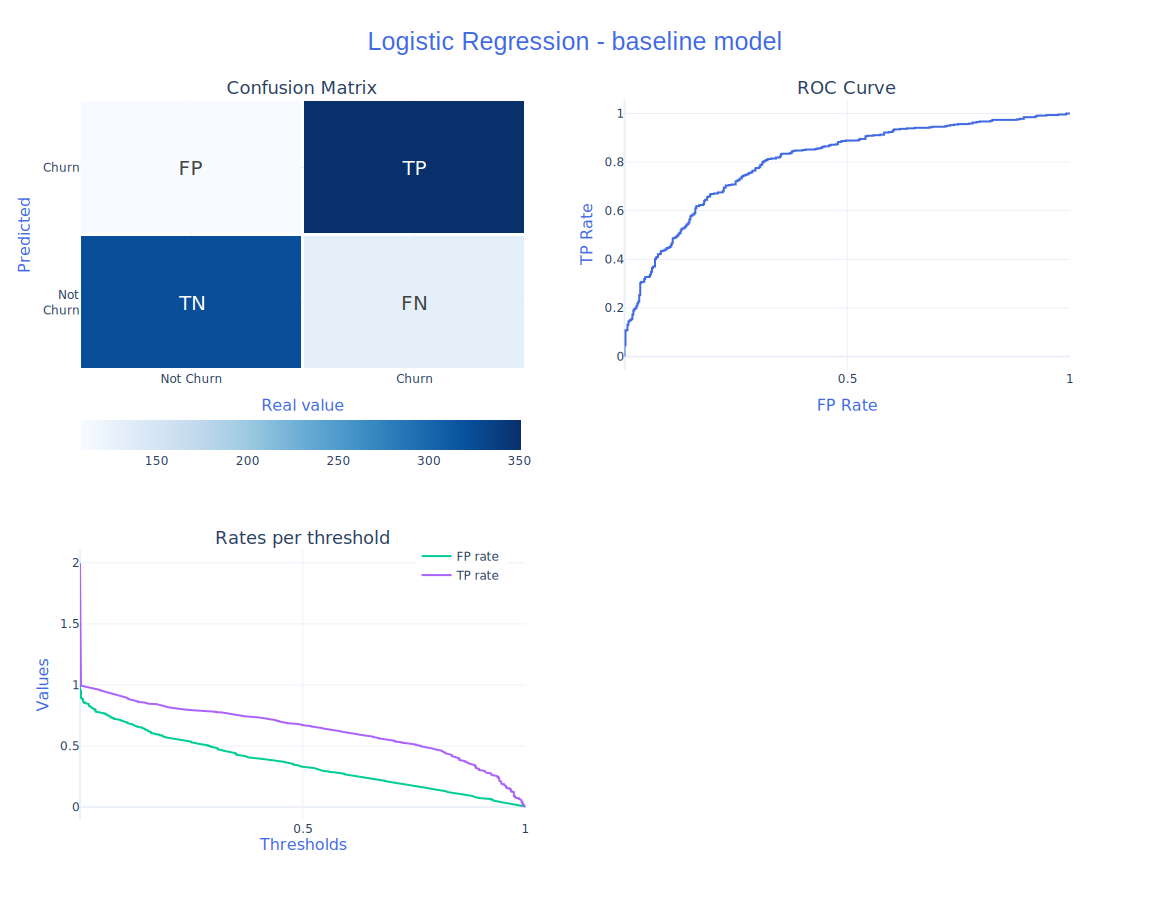

,Accuracy,Precision score,Recall score,F1 score,Area under ROC curve
0,0.739035,0.72973,0.764706,0.746809,0.738865


In [106]:
model.lr()

#### 3.3 Support Vector Classifier

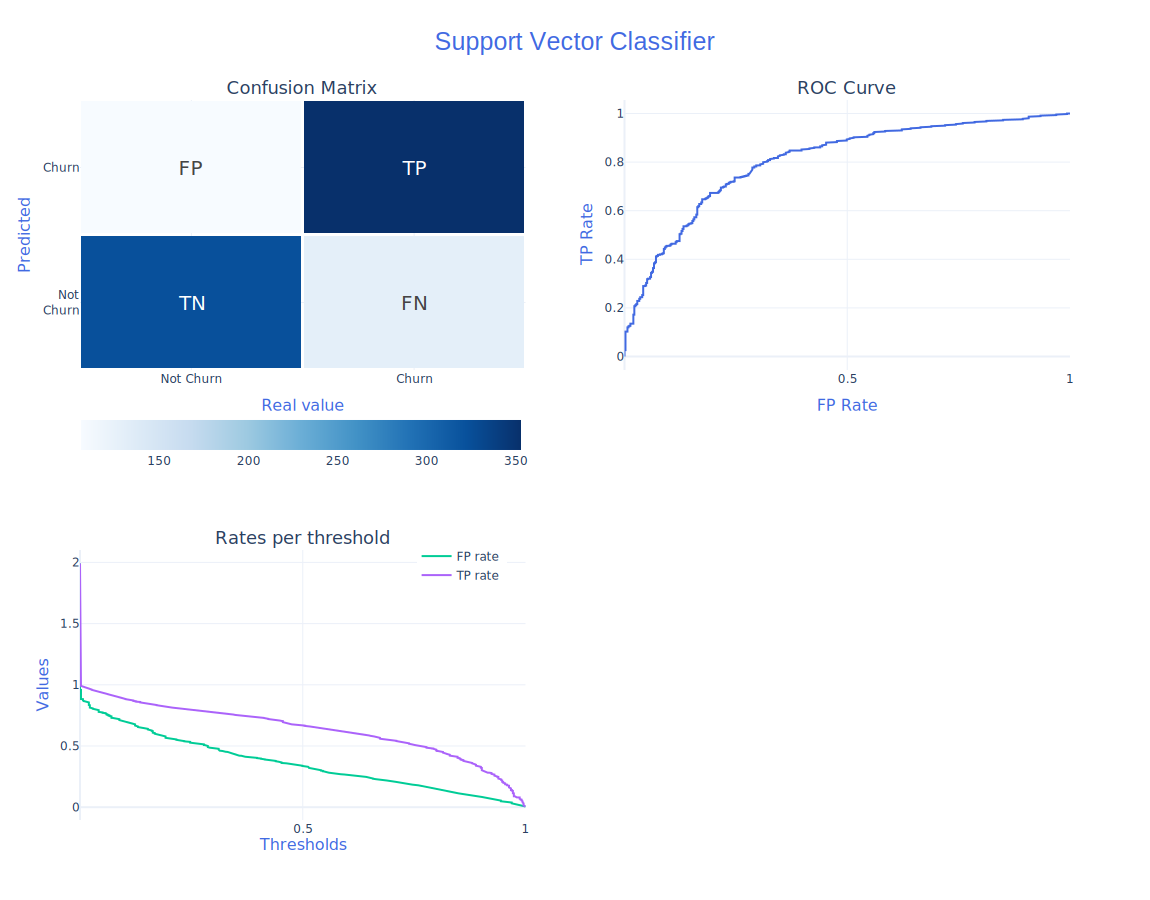

,Accuracy,Precision score,Recall score,F1 score,Area under ROC curve
0,0.741228,0.730849,0.769063,0.749469,0.741044


In [107]:
model.svc()

#### 3.4 K-Nearest Neighbors - Euclidean Metric

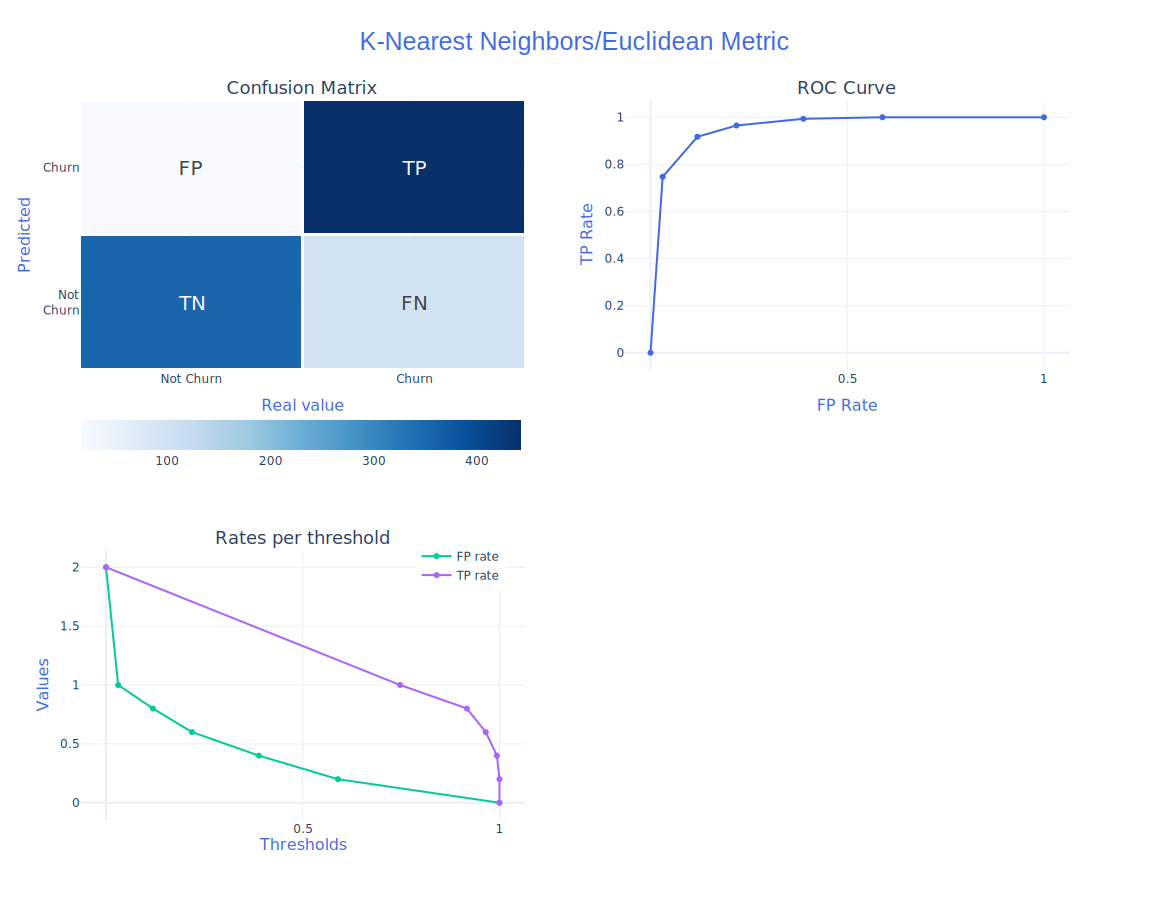

,Accuracy,Precision score,Recall score,F1 score,Area under ROC curve
0,0.873904,0.817343,0.965142,0.885115,0.873299


In [108]:
model.knn_euclidean()

#### 3.5 K-Nearest Neighbors - Chebyshev Metric


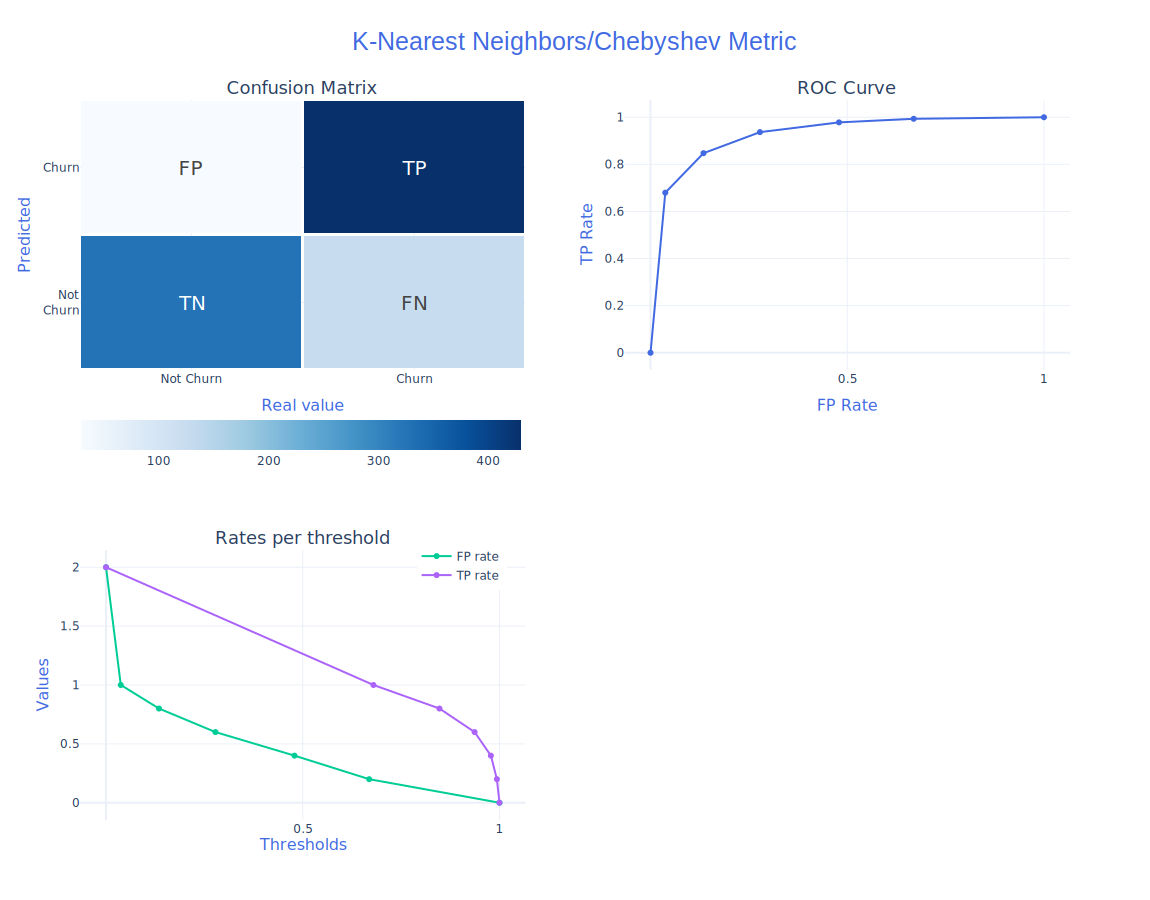

,Accuracy,Precision score,Recall score,F1 score,Area under ROC curve
0,0.830044,0.773381,0.936819,0.847291,0.829337


In [109]:
model.knn_chebyshev()

#### 3.6 Gaussian Naïve-Bayes

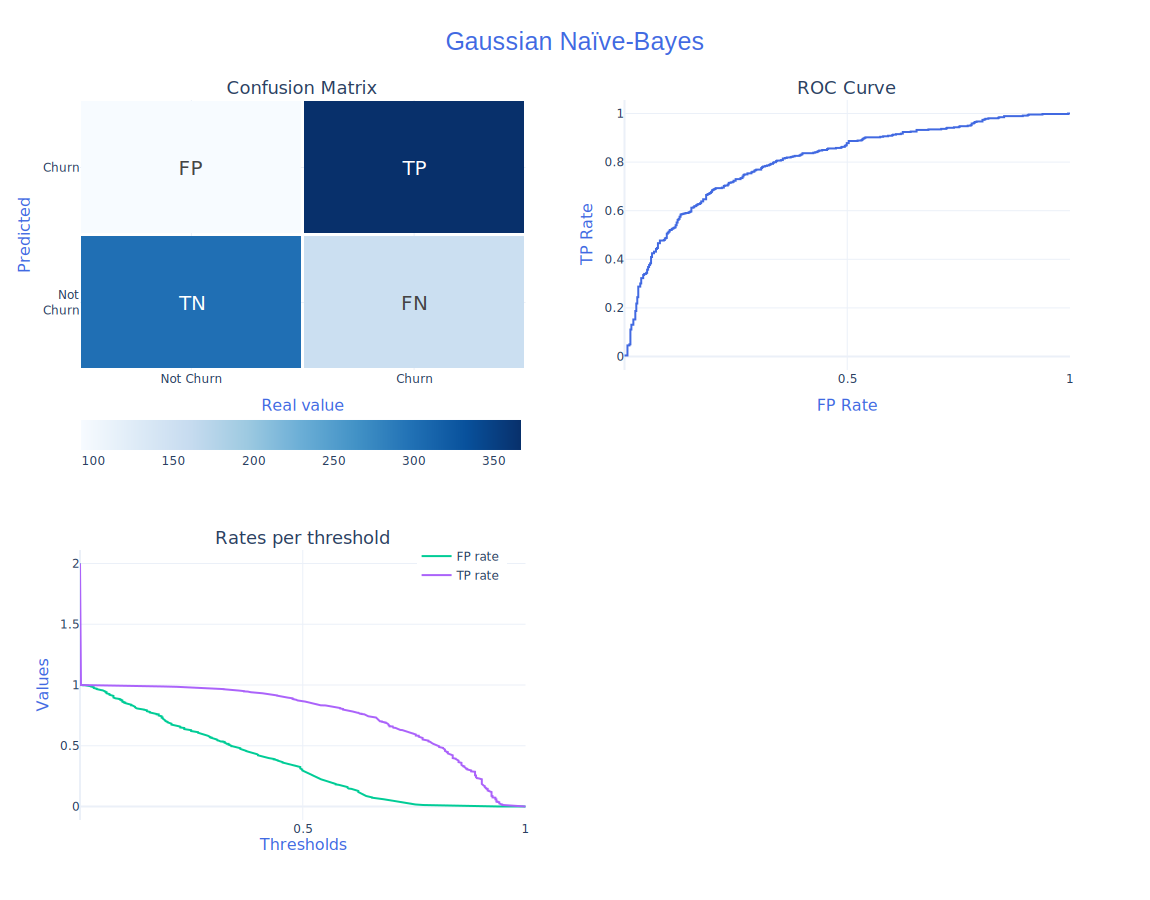

,Accuracy,Precision score,Recall score,F1 score,Area under ROC curve
0,0.73136,0.705769,0.799564,0.749745,0.730908


In [110]:
model.gnb()

#### 3.7 Bernoulli Naïve-Bayes

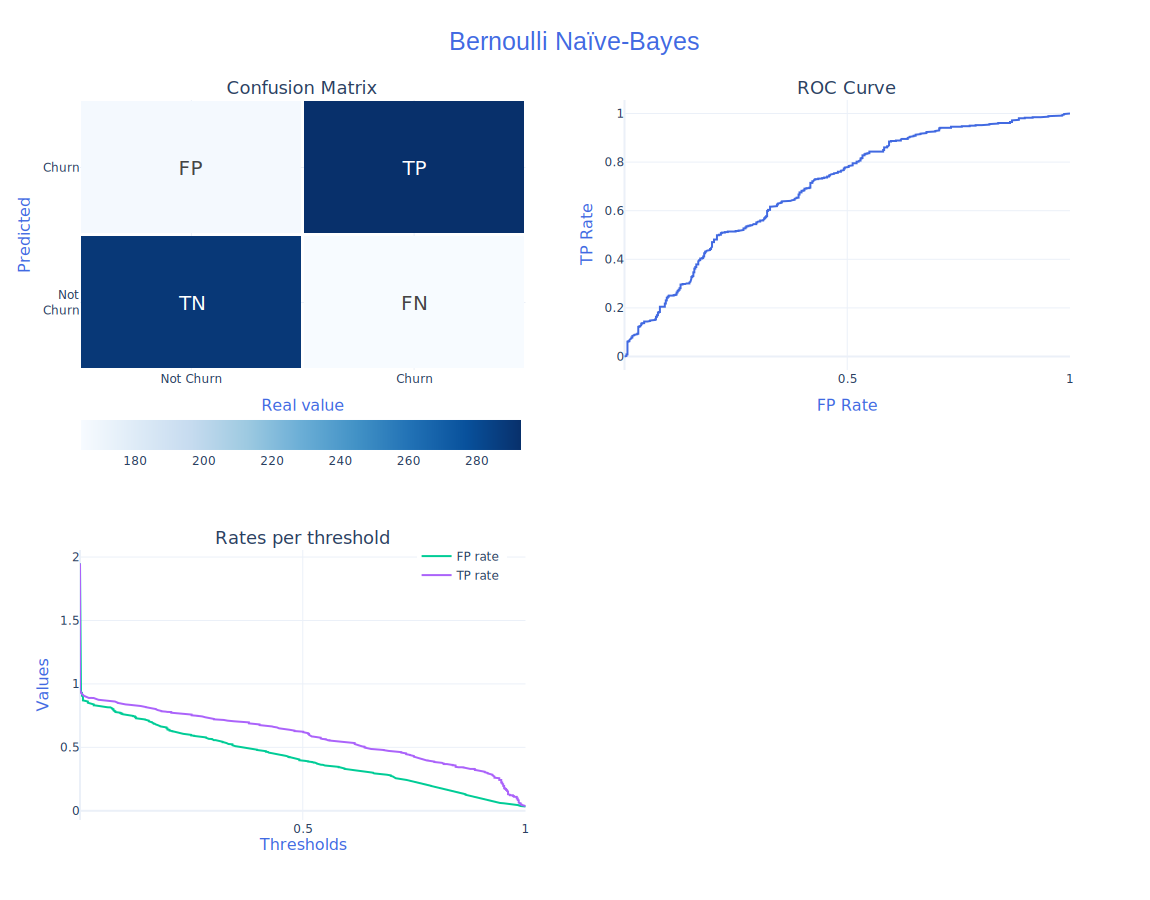

,Accuracy,Precision score,Recall score,F1 score,Area under ROC curve
0,0.638158,0.641138,0.638344,0.639738,0.638157


In [111]:
model.bnb()

#### 3.8 Decision Tree Classifier

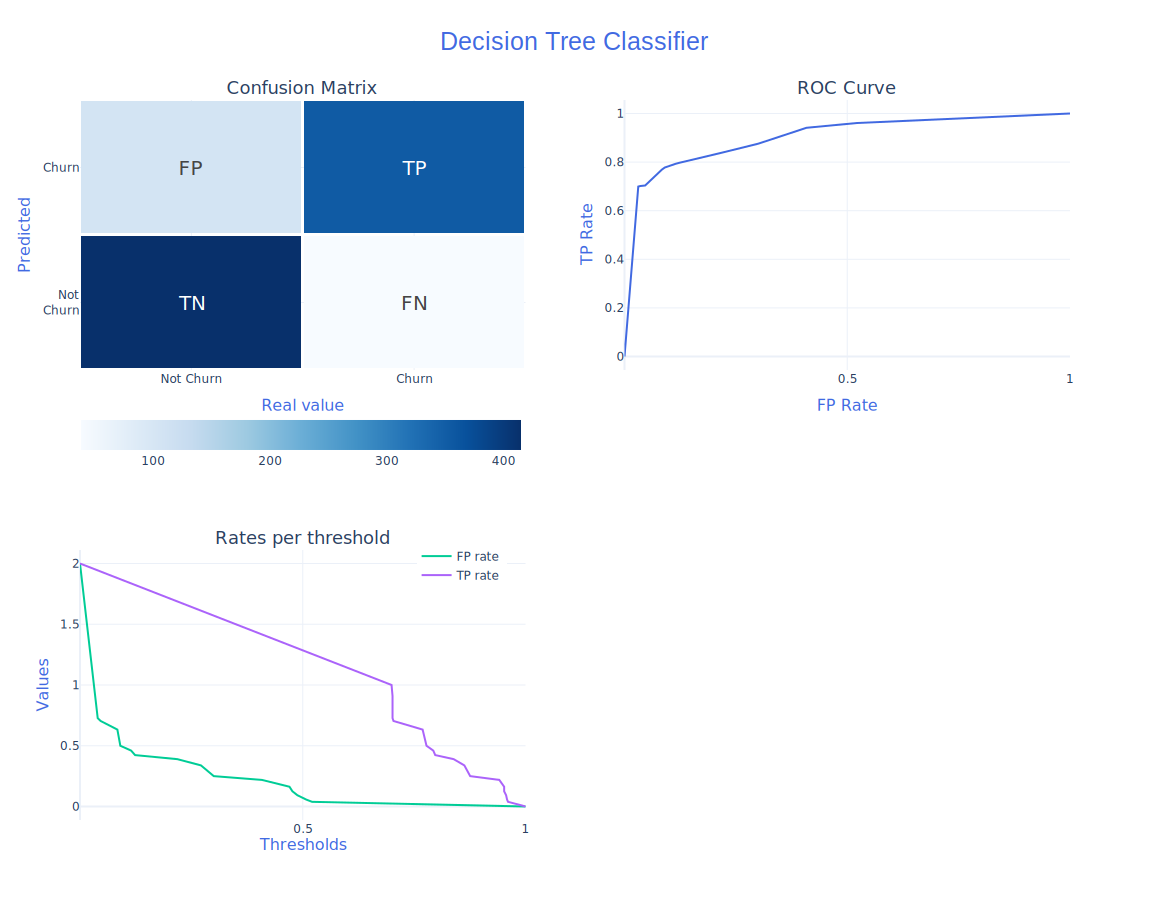

,Accuracy,Precision score,Recall score,F1 score,Area under ROC curve
0,0.842105,0.902813,0.769063,0.830588,0.842589


In [112]:
model.dtc()

#### 3.9 Random Forest Classifier

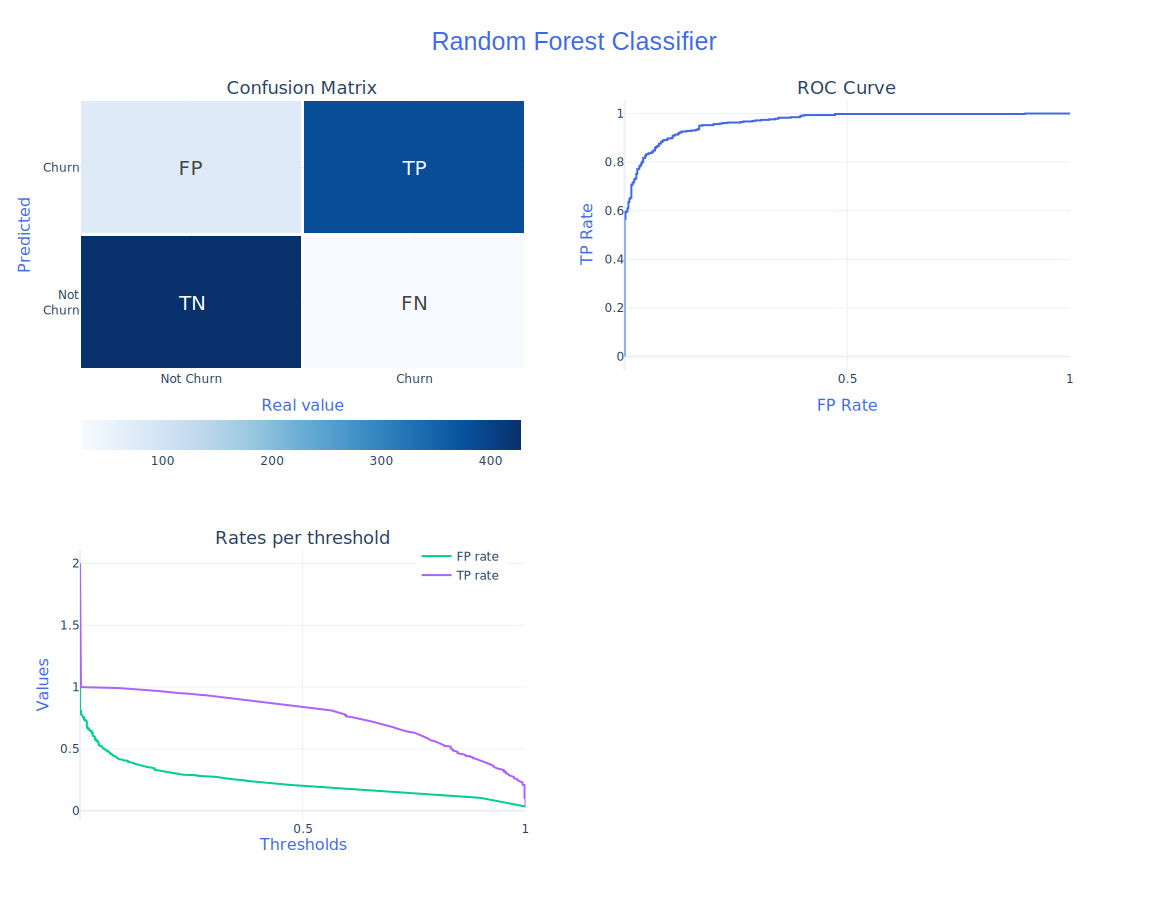

,Accuracy,Precision score,Recall score,F1 score,Area under ROC curve
0,0.889254,0.938725,0.834423,0.883506,0.889618


In [113]:
model.rfc()

#### 3.10 XGBoost Classifier

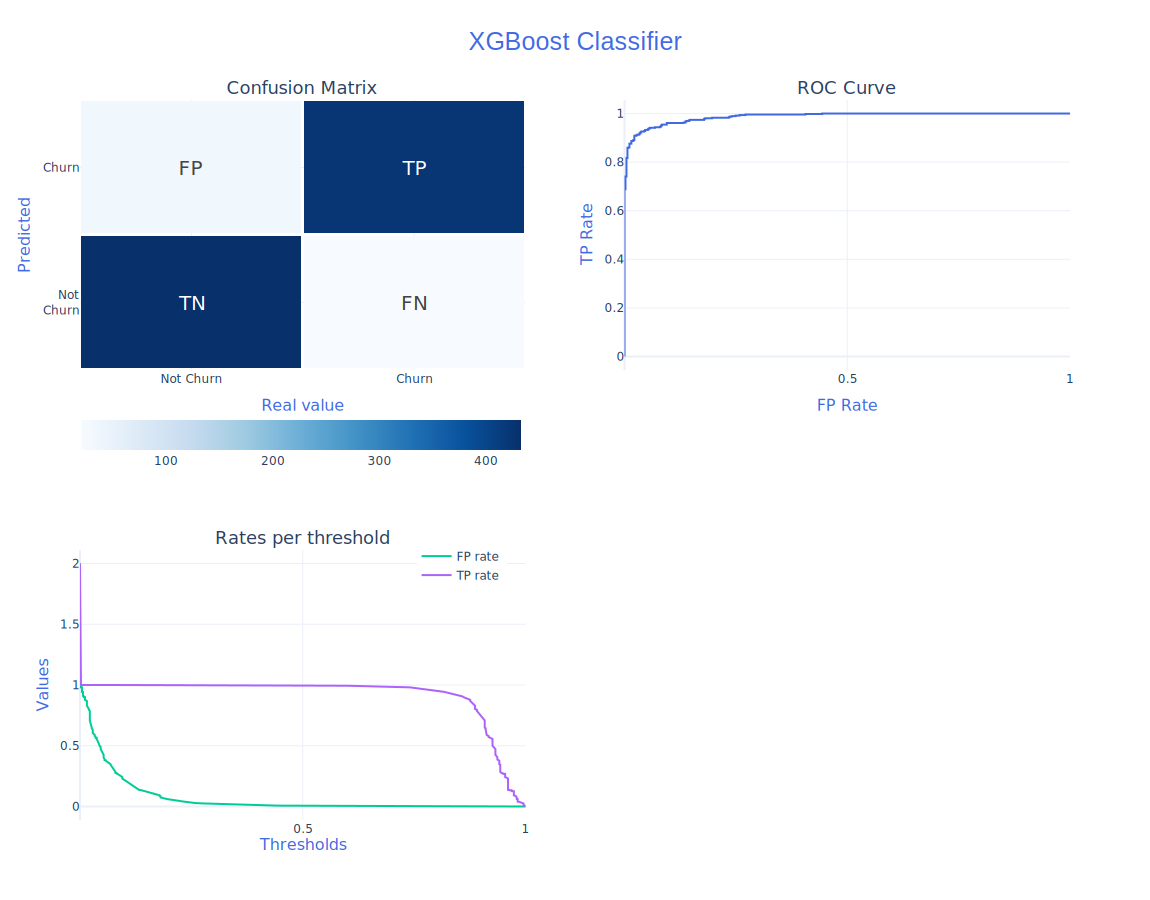

,Accuracy,Precision score,Recall score,F1 score,Area under ROC curve
0,0.940789,0.955056,0.925926,0.940265,0.940888


In [114]:
model.xgb()

## 4. Final report and models comparison

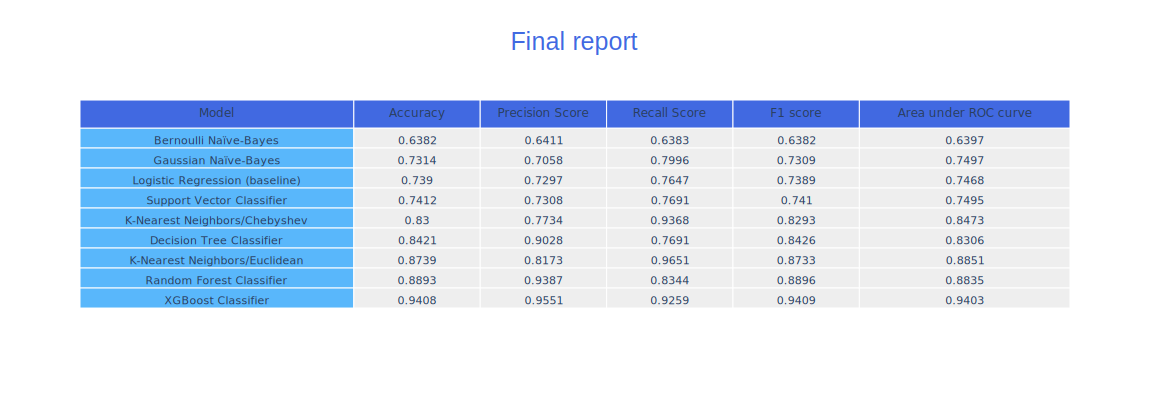

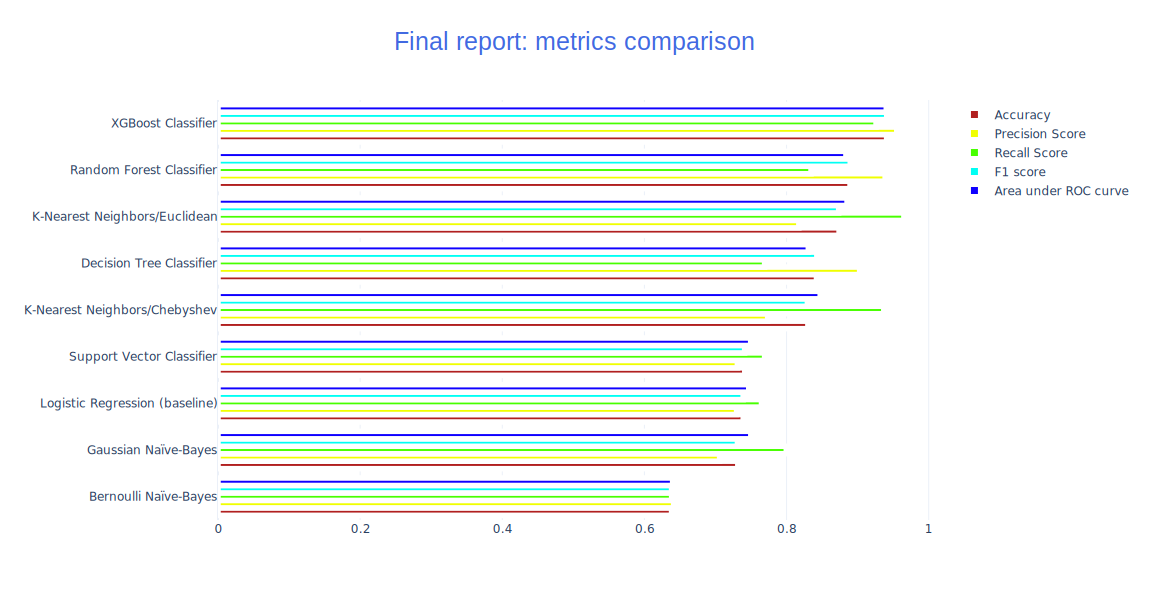

In [115]:
final_report = FinalReport()

final_report.metrics_table()
final_report.metricsplot()